In [423]:
import pyspark as ps
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
spark = ps.sql.SparkSession.builder.master("local[8]").appName("MountainData").getOrCreate()
sc = spark.sparkContext
spark.conf.set("spark.sql.caseSensitive", "true")

In [391]:
areas = spark.read.json("./SampleData/Clean/Areas.json")
routes = spark.read.json("./SampleData/Clean/Routes.json")
routeStats = spark.read.json("./SampleData/Clean/Stats.json")
difficultyReference = spark.read.json("././ReferenceData/DifficultyReference.json")

areas.createOrReplaceTempView("areas")
routes.createOrReplaceTempView("routes")
routeStats.createOrReplaceTempView("ticks")
difficultyReference.createOrReplaceTempView("difficultyRef")

In [353]:
def getSubAreas(initialAreaId: int, tempViewName: str = "subAreas") -> None:
    """
    This function creates a spark view consisting of all subordinate areas underneath
    the specified areaId. This creates the spark temp view {tempViewName}
    :param initialAreaId: AreaId of area for which you want sub areas
    :param tempViewName: Name of spark temp view to create. Defaults to "subAreas"
    :return: None
    """
    subAreas = areas.filter(f"AreaId = {initialAreaId}")
    subAreaCount = 1
    subAreaCountNew = 0
    while subAreaCount != subAreaCountNew:
        subAreaCount = subAreas.count()
        p = subAreas.select(col("AreaId").alias("p_AreaId"), col("ParentAreaId").alias("p_ParentAreaId"), col("URL").alias("p_URL"))
        subordinates = p.join(areas, on=p.p_AreaId == areas.ParentAreaId, how="inner").select(col("AreaId"), col("ParentAreaId"), col("URL"))
        subAreas = subAreas.union(subordinates).distinct()
        subAreaCountNew = subAreas.count()

    subAreas.createOrReplaceTempView(tempViewName)
# subAreas.show(200, False)

In [ ]:
getSubAreas(105744246)


In [386]:
# Route tick count divided by number of routes at the grade
query = """
with routeCounts as (
    select  d.DifficultyBucket,
            count(*) as route_count
        from routes r
        inner join subAreas s
            on s.AreaId = r.ParentAreaId
        inner join difficultyRef d
            on d.Difficulty = r.Difficulty
        group by d.DifficultyBucket
)
select  d.BucketName,
        d.DifficultyBucket,
        count(*) / c.route_count as freq
    from routes r
    inner join subAreas s
        on s.AreaId = r.ParentAreaId
    inner join difficultyRef d
        on d.Difficulty = r.Difficulty
    inner join ticks t
        on t.RouteId = r.RouteId
    inner join routeCounts c
        on c.DifficultyBucket = d.DifficultyBucket
    where d.RatingSystem = 'YDS'
        and lower(t.TickInfo) like '%lead / onsight%'
    group by d.BucketName,
        d.DifficultyBucket,
        c.route_count
    order by d.DifficultyBucket
"""

results = spark.sql(query)
results.show(100, False)
climbs = results.collect()

+----------+----------------+----+
|BucketName|DifficultyBucket|freq|
+----------+----------------+----+
|5th       |2               |13  |
|5.2       |5               |9   |
|5.3       |6               |123 |
|5.4       |7               |225 |
|5.5       |8               |393 |
|5.6       |9               |970 |
|5.7       |10              |2360|
|5.8       |11              |1844|
|5.9       |12              |1759|
|5.10-     |13              |1341|
|5.10+     |14              |639 |
|5.11-     |15              |542 |
|5.11+     |16              |141 |
|5.12-     |17              |24  |
|5.12+     |18              |8   |
+----------+----------------+----+



In [389]:
query = """
select  d.BucketName,
        d.DifficultyBucket,
        count(*) as freq
    from routes r
    inner join subAreas s
        on s.AreaId = r.ParentAreaId
    inner join difficultyRef d
        on d.Difficulty = r.Difficulty
    inner join ticks t
        on t.RouteId = r.RouteId
    where d.RatingSystem = 'YDS'
        and lower(t.TickInfo) like '%lead / onsight%'
    group by d.BucketName,
        d.DifficultyBucket
    order by d.DifficultyBucket
"""

results = spark.sql(query)
results.show(100, False)
climbs = results.collect()


+----------+----------------+----+
|BucketName|DifficultyBucket|freq|
+----------+----------------+----+
|5th       |2               |13  |
|5.2       |5               |9   |
|5.3       |6               |123 |
|5.4       |7               |225 |
|5.5       |8               |393 |
|5.6       |9               |970 |
|5.7       |10              |2360|
|5.8       |11              |1844|
|5.9       |12              |1759|
|5.10-     |13              |1341|
|5.10+     |14              |639 |
|5.11-     |15              |542 |
|5.11+     |16              |141 |
|5.12-     |17              |24  |
|5.12+     |18              |8   |
+----------+----------------+----+



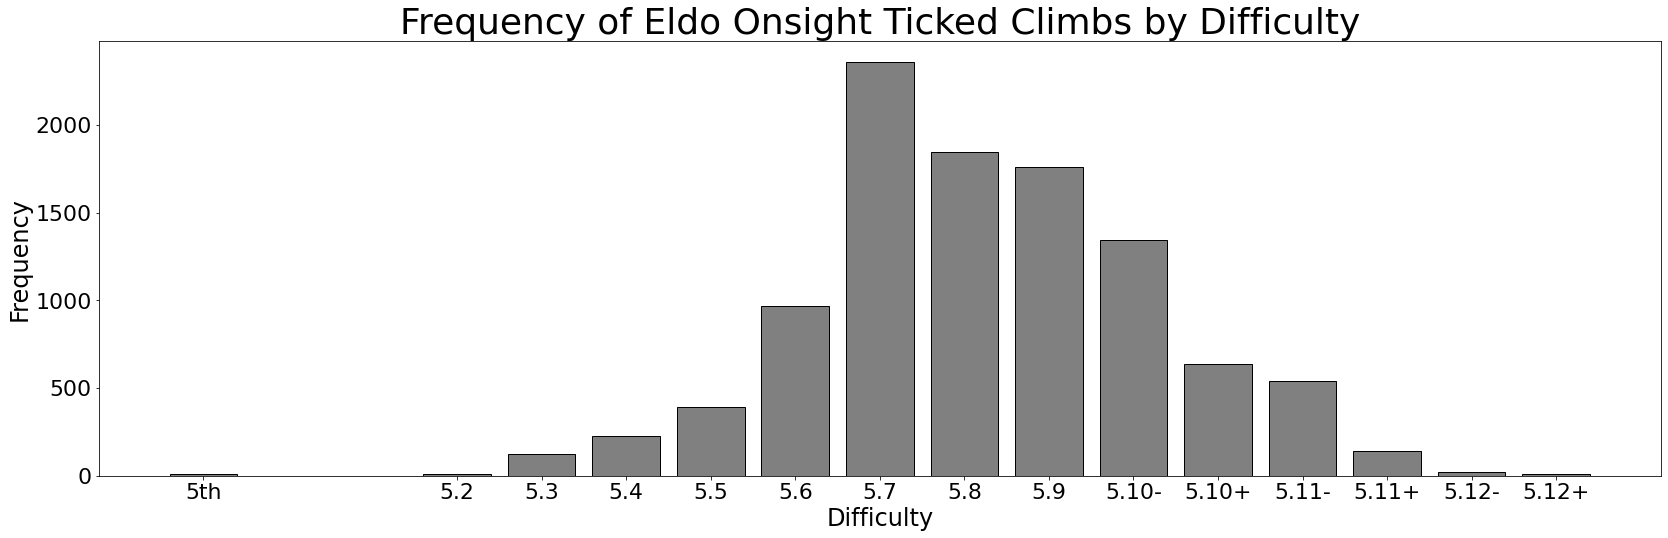

In [390]:
fig, ax = plt.subplots(figsize=(28,8))
climb_buckets = [x["DifficultyBucket"] for x in climbs]
bucket_names = [x["BucketName"] for x in climbs]
climb_freqs = [x["freq"] for x in climbs]

ax.bar(climb_buckets, climb_freqs, color="grey", edgecolor="black");
ax.set_xticks(climb_buckets[::1])
ax.set_xticklabels(bucket_names[::1], fontsize=22);

# ax.set_yticklabels(sorted(climb_freqs), fontsize=22)

ax.set_xlabel("Difficulty", fontsize=24)
ax.set_ylabel("Frequency", fontsize=24)

ax.set_title("Frequency of Eldo Onsight Ticked Climbs by Difficulty", fontsize=36)

plt.savefig("./img/frequency_of_eldo_climbs.png")

In [403]:
query = """
with routeCounts as (
    select  d.DifficultyBucket,
            count(*) as route_count
        from routes r
        inner join difficultyRef d
            on d.Difficulty = r.Difficulty
        where d.RatingSystem = 'YDS'
            and lower(r.Type) like '%trad%'
        group by d.DifficultyBucket
)
select  d.DifficultyBucket,
        d.BucketName,
        count(*)/c.route_count as freq
    from routes r
    inner join ticks t
        on t.RouteId = r.RouteId
    inner join difficultyRef d
        on d.Difficulty = r.Difficulty
    inner join routeCounts c
        on c.DifficultyBucket = d.DifficultyBucket
    where d.RatingSystem = 'YDS'
        and lower(r.Type) like '%trad%'
    group by d.DifficultyBucket,
        d.BucketName,
        c.route_count
    order by d.DifficultyBucket
"""

results = spark.sql(query)
results.show(30, False)
tradClimbs = results.collect()

+----------------+----------+------------------+
|DifficultyBucket|BucketName|freq              |
+----------------+----------+------------------+
|0               |3rd       |3.5               |
|1               |4th       |24.2              |
|2               |5th       |69.33333333333333 |
|3               |5.0       |24.454545454545453|
|4               |5.1       |29.5              |
|5               |5.2       |40.2              |
|6               |5.3       |75.21153846153847 |
|7               |5.4       |70.36567164179104 |
|8               |5.5       |59.39655172413793 |
|9               |5.6       |84.37222222222222 |
|10              |5.7       |85.63106796116504 |
|11              |5.8       |58.76334340382679 |
|12              |5.9       |48.069651741293534|
|13              |5.10-     |37.194524495677236|
|14              |5.10+     |31.311764705882354|
|15              |5.11-     |22.453149001536097|
|16              |5.11+     |16.353982300884955|
|17              |5.

In [404]:
query = """
with routeCounts as (
    select  d.DifficultyBucket,
            count(*) as route_count
        from routes r
        inner join difficultyRef d
            on d.Difficulty = r.Difficulty
        where d.RatingSystem = 'YDS'
            and lower(r.Type) not like '%trad%'
            and lower(r.Type) like '%sport%'
        group by d.DifficultyBucket
)
select  d.DifficultyBucket,
        d.BucketName,
        count(*)/c.route_count as freq
    from routes r
    inner join ticks t
        on t.RouteId = r.RouteId
    inner join difficultyRef d
        on d.Difficulty = r.Difficulty
    inner join routeCounts c
        on c.DifficultyBucket = d.DifficultyBucket
    where d.RatingSystem = 'YDS'
        and lower(r.Type) not like '%trad%'
        and lower(r.Type) like '%sport%'
    group by d.DifficultyBucket,
        d.BucketName,
        c.route_count
    order by d.DifficultyBucket
"""

results = spark.sql(query)
results.show(30, False)
sportClimbs = results.collect()


+----------------+----------+------------------+
|DifficultyBucket|BucketName|freq              |
+----------------+----------+------------------+
|3               |5.0       |59.0              |
|5               |5.2       |67.0              |
|6               |5.3       |67.0              |
|7               |5.4       |5.857142857142857 |
|8               |5.5       |81.0625           |
|9               |5.6       |106.5945945945946 |
|10              |5.7       |97.45454545454545 |
|11              |5.8       |120.97979797979798|
|12              |5.9       |119.33712121212122|
|13              |5.10-     |82.82272727272728 |
|14              |5.10+     |63.22222222222222 |
|15              |5.11-     |50.42369020501139 |
|16              |5.11+     |36.455621301775146|
|17              |5.12-     |32.011019283746556|
|18              |5.12+     |13.594771241830065|
|19              |5.13-     |7.073684210526316 |
|20              |5.13+     |2.0               |
|21              |5.

In [443]:
query = """
select  d.DifficultyBucket,
        d.BucketName,
        count(*) as freq
    from routes r
    inner join ticks t
        on t.RouteId = r.RouteId
    inner join difficultyRef d
        on d.Difficulty = r.Difficulty
    where d.RatingSystem = 'YDS'
        and lower(r.Type) not like '%trad%'
        and lower(r.Type) like '%sport%'
    group by d.DifficultyBucket,
        d.BucketName
    order by d.DifficultyBucket
"""

results = spark.sql(query)
results.show(30, False)
sportClimbs = results.collect()

query = """
select  d.DifficultyBucket,
        d.BucketName,
        count(*) as freq
    from routes r
    inner join ticks t
        on t.RouteId = r.RouteId
    inner join difficultyRef d
        on d.Difficulty = r.Difficulty
    where d.RatingSystem = 'YDS'
        and lower(r.Type) like '%trad%'
    group by d.DifficultyBucket,
        d.BucketName
    order by d.DifficultyBucket
"""

results = spark.sql(query)
results.show(30, False)
tradClimbs = results.collect()

+----------------+----------+-----+
|DifficultyBucket|BucketName|freq |
+----------------+----------+-----+
|3               |5.0       |59   |
|5               |5.2       |67   |
|6               |5.3       |67   |
|7               |5.4       |41   |
|8               |5.5       |1297 |
|9               |5.6       |3944 |
|10              |5.7       |10720|
|11              |5.8       |23954|
|12              |5.9       |31505|
|13              |5.10-     |36442|
|14              |5.10+     |22191|
|15              |5.11-     |22136|
|16              |5.11+     |12322|
|17              |5.12-     |11620|
|18              |5.12+     |2080 |
|19              |5.13-     |672  |
|20              |5.13+     |62   |
|21              |5.14-     |10   |
+----------------+----------+-----+

+----------------+----------+-----+
|DifficultyBucket|BucketName|freq |
+----------------+----------+-----+
|0               |3rd       |7    |
|1               |4th       |242  |
|2               |5th      

In [446]:
def plotFrequencies(ax, data, title):
    climb_buckets = [x["DifficultyBucket"] for x in data]
    bucket_names = [x["BucketName"] for x in data]
    climb_freqs = [x["freq"] for x in data]

    ax.bar(climb_buckets, climb_freqs, color="grey", edgecolor="black");
    ax.set_xticks(climb_buckets[::1])
    ax.set_xticklabels(bucket_names[::1], fontsize=22);

    # ax.set_yticklabels(sorted(climb_freqs), fontsize=22)

    ax.set_xlabel("Difficulty", fontsize=24)
    ax.set_ylabel("Frequency", fontsize=24)

    ax.set_title(title, fontsize=36)

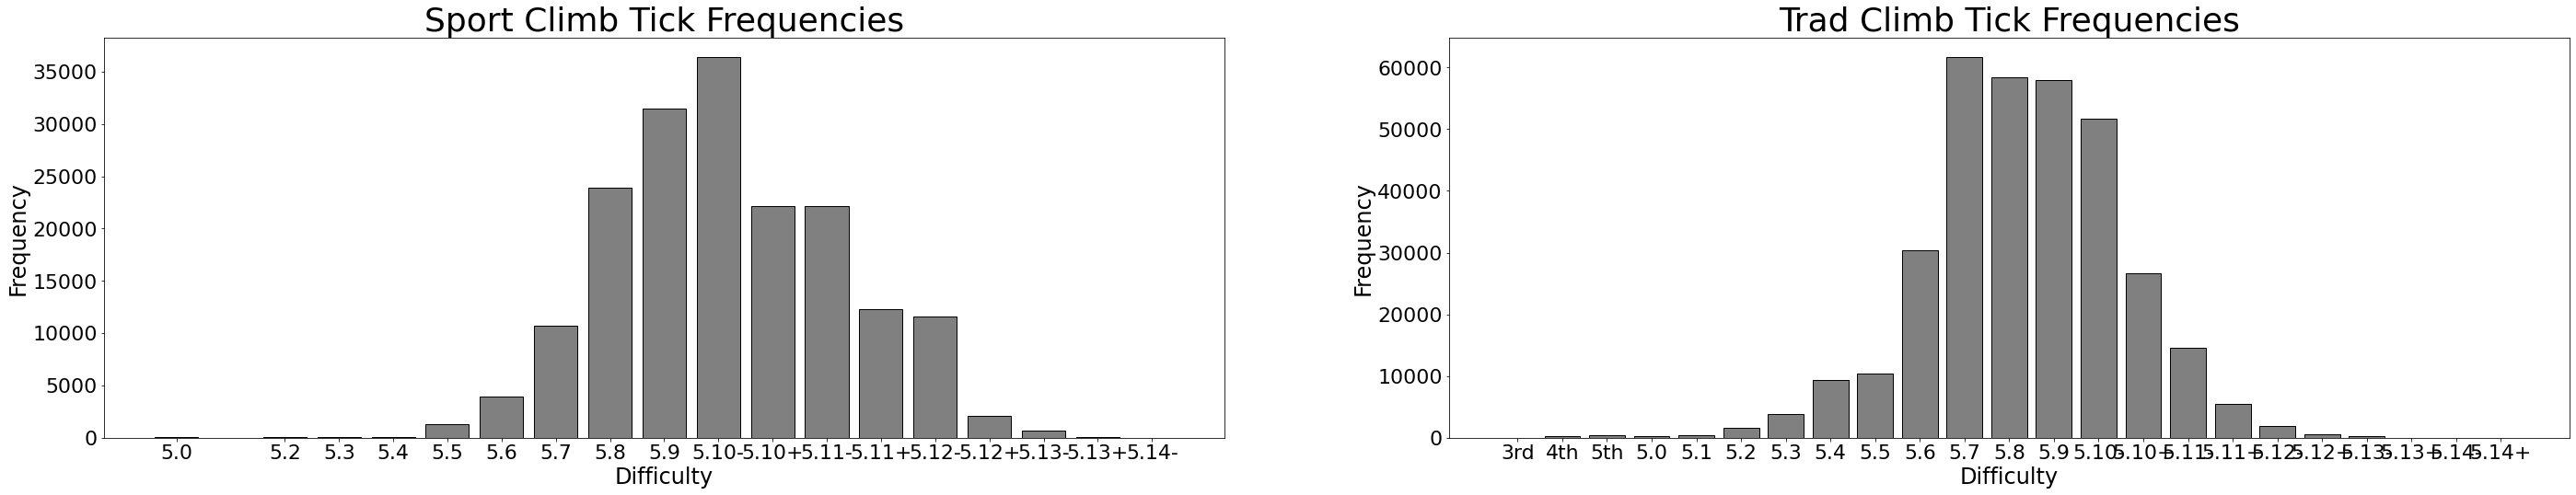

In [456]:
fig, axs = plt.subplots(1,2, figsize=(48,8))

plotFrequencies(axs[0], sportClimbs, "Sport Climb Tick Frequencies")
plotFrequencies(axs[1], tradClimbs, "Trad Climb Tick Frequencies")

plt.savefig("./img/sport_v_trad_climb_ticks.png")

In [461]:
query = """
select  d.DifficultyBucket,
        d.BucketName,
        count(*) as freq
    from routes r
    inner join ticks t
        on t.RouteId = r.RouteId
    inner join difficultyRef d
        on d.Difficulty = r.Difficulty
    where d.RatingSystem = 'YDS'
        and lower(r.Type) not like '%trad%'
        and lower(r.Type) like '%sport%'
        and lower(t.TickInfo) like '%lead / onsight%'
    group by d.DifficultyBucket,
        d.BucketName
    order by d.DifficultyBucket
"""

results = spark.sql(query)
results.show(30, False)
sportOnsightClimbs = results.collect()

+----------------+----------+----+
|DifficultyBucket|BucketName|freq|
+----------------+----------+----+
|3               |5.0       |18  |
|5               |5.2       |20  |
|6               |5.3       |14  |
|7               |5.4       |10  |
|8               |5.5       |396 |
|9               |5.6       |1083|
|10              |5.7       |3021|
|11              |5.8       |6250|
|12              |5.9       |7698|
|13              |5.10-     |8176|
|14              |5.10+     |4509|
|15              |5.11-     |3815|
|16              |5.11+     |1691|
|17              |5.12-     |983 |
|18              |5.12+     |40  |
|19              |5.13-     |9   |
|20              |5.13+     |1   |
+----------------+----------+----+



In [462]:
query = """
select  d.DifficultyBucket,
        d.BucketName,
        count(*) as freq
    from routes r
    inner join ticks t
        on t.RouteId = r.RouteId
    inner join difficultyRef d
        on d.Difficulty = r.Difficulty
    where d.RatingSystem = 'YDS'
        and lower(r.Type) like '%trad%'
        and lower(t.TickInfo) like '%lead / onsight%'
    group by d.DifficultyBucket,
        d.BucketName
    order by d.DifficultyBucket
"""

results = spark.sql(query)
results.show(30, False)
tradOnsightClimbs = results.collect()

+----------------+----------+-----+
|DifficultyBucket|BucketName|freq |
+----------------+----------+-----+
|1               |4th       |12   |
|2               |5th       |24   |
|3               |5.0       |30   |
|4               |5.1       |55   |
|5               |5.2       |296  |
|6               |5.3       |714  |
|7               |5.4       |1634 |
|8               |5.5       |1831 |
|9               |5.6       |5891 |
|10              |5.7       |11822|
|11              |5.8       |11030|
|12              |5.9       |10057|
|13              |5.10-     |8420 |
|14              |5.10+     |3490 |
|15              |5.11-     |1435 |
|16              |5.11+     |421  |
|17              |5.12-     |101  |
|18              |5.12+     |22   |
|19              |5.13-     |3    |
|22              |5.14+     |2    |
+----------------+----------+-----+



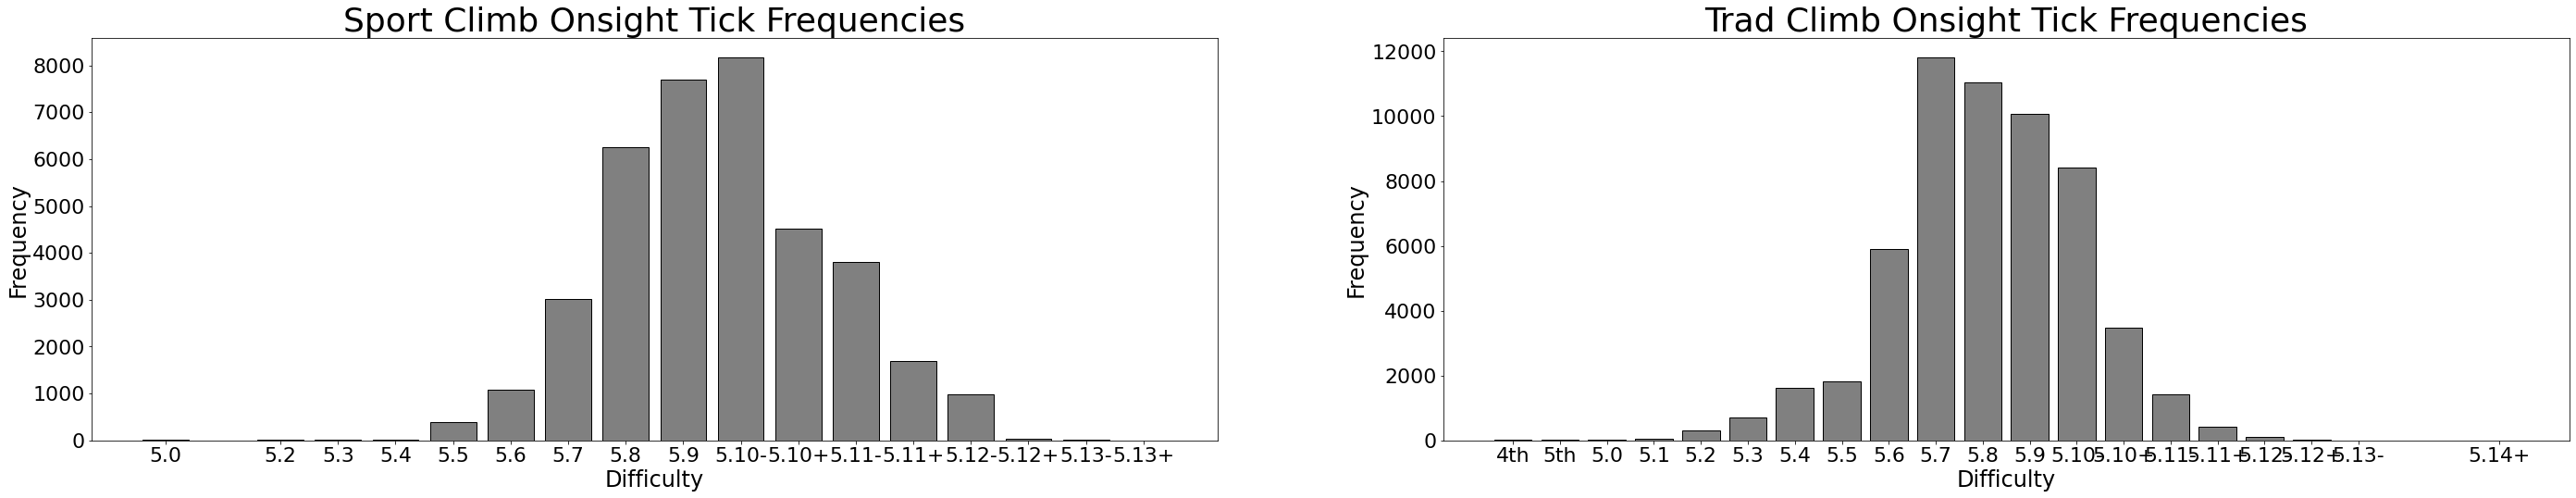

In [463]:
fig, axs = plt.subplots(1,2, figsize=(48,8))

plotFrequencies(axs[0], sportOnsightClimbs, "Sport Climb Onsight Tick Frequencies")
plotFrequencies(axs[1], tradOnsightClimbs, "Trad Climb Onsight Tick Frequencies")

plt.savefig("./img/sport_v_trad_onsight_climb_ticks.png")

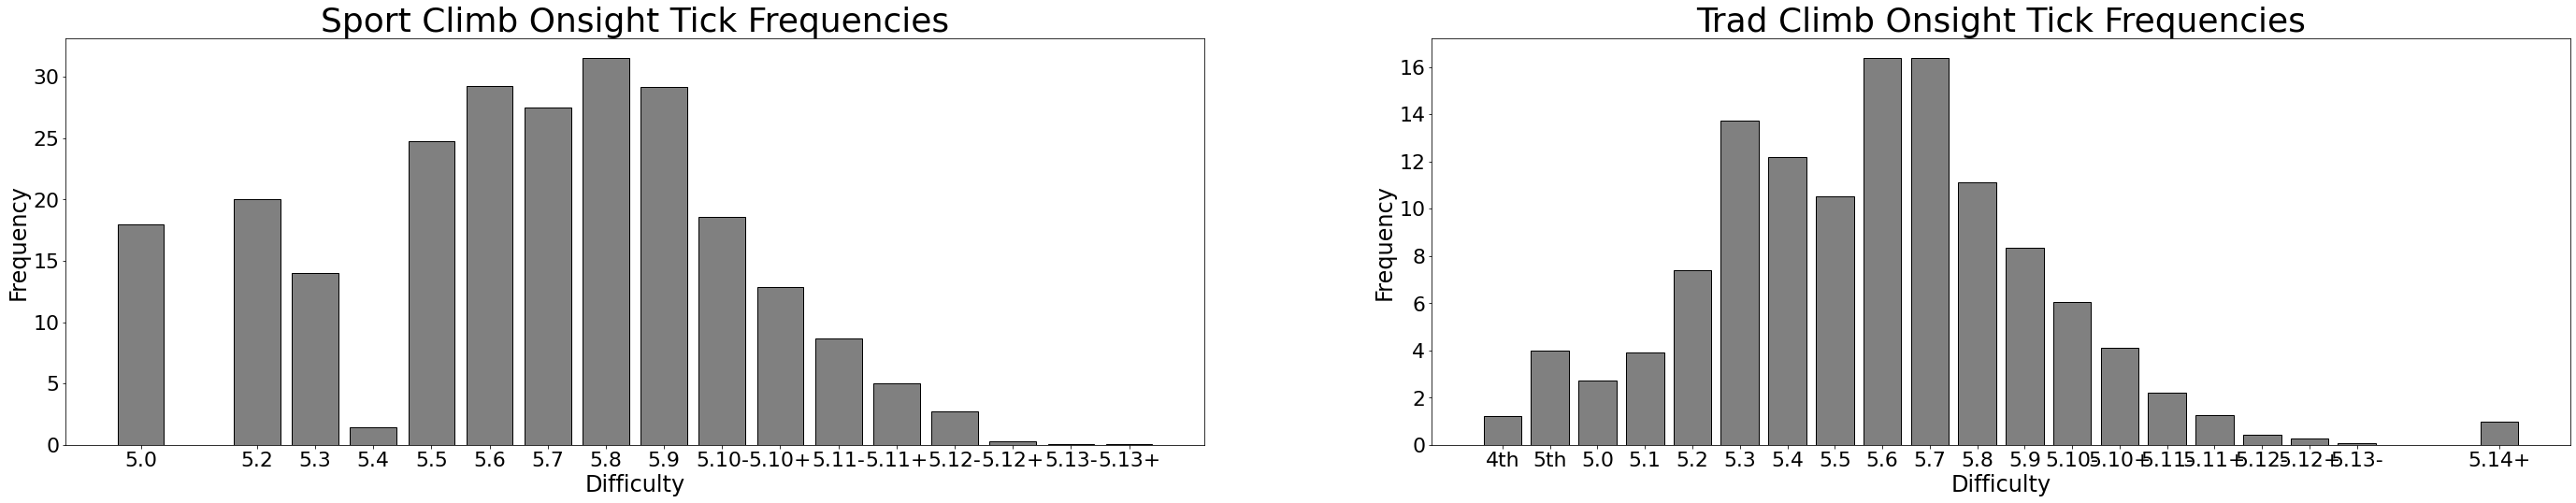

In [411]:
query = """
select  d.DifficultyRanking
    from routes r
    inner join ticks t
        on t.RouteId = r.RouteId
    inner join difficultyRef d
        on d.Difficulty = r.Difficulty
    where lower(r.Type) like '%trad%'
        and lower(t.TickInfo) like '%lead / onsight%'
"""

result = spark.sql(query)
result.show(25, False)
tradTicks = result.collect()
tradTicks = np.array([x["DifficultyRanking"] for x in tradTicks])

query = """
select  d.DifficultyRanking
    from routes r
    inner join ticks t
        on t.RouteId = r.RouteId
    inner join difficultyRef d
        on d.Difficulty = r.Difficulty
    where lower(r.Type) not like '%trad%'
        and lower(r.Type) like '%sport%'
        and lower(t.TickInfo) like '%lead / onsight%'
"""

result = spark.sql(query)
result.show(25, False)
sportTicks = result.collect()
sportTicks = np.array([x["DifficultyRanking"] for x in sportTicks])

In [470]:
test = stats.ttest_ind(sportTicks-5.5, tradTicks, equal_var=False)
test

Ttest_indResult(statistic=2.8843059952601857, pvalue=0.003923914319953529)

In [484]:
meanSport = np.mean(sportTicks)
meanTrad = np.mean(tradTicks)
semSport = np.std(sportTicks)/np.sqrt(sportTicks.size)
semTrad = np.std(tradTicks)/np.sqrt(tradTicks.size)
meanSport, meanTrad, semSport, semTrad

(34.29053373615307,
 28.650619654389946,
 0.03948611561124719,
 0.0281760613588229)

In [481]:
query = """
with trad as (
    select  t.UserId,
            avg(d.DifficultyRanking) as DifficultyRanking
        from routes r
        inner join ticks t
            on t.RouteId = r.RouteId
        inner join difficultyRef d
            on d.Difficulty = r.Difficulty
        where lower(r.Type) like '%trad%'
            and lower(t.TickInfo) like '%lead / onsight%'
        group by t.UserId
        having count(*) > 20
),
sport as (
    select  t.UserId,
            avg(d.DifficultyRanking) as DifficultyRanking
        from routes r
        inner join ticks t
            on t.RouteId = r.RouteId
        inner join difficultyRef d
            on d.Difficulty = r.Difficulty
        where lower(r.Type) not like '%trad%'
            and lower(r.Type) like '%sport%'
            and lower(t.TickInfo) like '%lead / onsight%'
        group by t.UserId
        having count(*) > 20
)
select  s.DifficultyRanking - t.DifficultyRanking as Difference
    from trad t
    inner join sport s
        on s.UserId = t.UserId
"""

result = spark.sql(query)
result.show(25, False)
diffs = result.collect()
diffs = np.array([x["Difference"] for x in diffs])

+------------------+
|Difference        |
+------------------+
|6.8552380952380965|
|5.39537997991296  |
|9.324786324786324 |
|5.070542635658917 |
|6.77              |
|2.8083976833976863|
|2.30462772905393  |
|5.101052631578945 |
|4.871318822023049 |
|8.756410256410252 |
|5.741695205479452 |
|4.623745819397996 |
|6.37760910815939  |
|12.825396825396826|
|4.747126436781613 |
|5.654761904761905 |
|0.8150819672131142|
|5.827235547695366 |
|4.938735177865617 |
|3.37142857142857  |
|6.468559837728193 |
|4.672248803827749 |
|1.599865807497057 |
|6.987558987558984 |
|11.111888111888113|
+------------------+
only showing top 25 rows



In [487]:
test2 = stats.ttest_1samp(diffs, 5.5)
test2


Ttest_1sampResult(statistic=0.6844204511744648, pvalue=0.4954683973651688)

In [485]:
meanDiffs = diffs.mean()
semDiffs = diffs.std()/np.sqrt(diffs.size)
meanDiffs, semDiffs


(5.687744576710641, 0.2728003862786003)

In [ ]:
fig, ax = plt.subplots(figsize=(28,8))
climb_buckets = [x["DifficultyBucket"] for x in climbs]
bucket_names = [x["BucketName"] for x in climbs]
climb_freqs = [x["freq"] for x in climbs]

ax.bar(climb_buckets, climb_freqs, color="grey", edgecolor="black");
ax.set_xticks(climb_buckets[::1])
ax.set_xticklabels(bucket_names[::1], fontsize=22);

# ax.set_yticklabels(sorted(climb_freqs), fontsize=22)

ax.set_xlabel("Difficulty", fontsize=24)
ax.set_ylabel("Frequency", fontsize=24)

ax.set_title("Frequency of Your Ticked Trad Climbs by Difficulty", fontsize=36)

plt.savefig("./img/frequency_of_climbs.png")

In [ ]:
fig, ax = plt.subplots(figsize=(28,8))
climb_buckets = [x["DifficultyBucket"] for x in climbs]
bucket_names = [x["BucketName"] for x in climbs]
climb_freqs = [x["freq"] for x in climbs]

ax.bar(climb_buckets, climb_freqs, color="grey", edgecolor="black");
ax.set_xticks(climb_buckets[::1])
ax.set_xticklabels(bucket_names[::1], fontsize=22);

# ax.set_yticklabels(sorted(climb_freqs), fontsize=22)

ax.set_xlabel("Difficulty", fontsize=24)
ax.set_ylabel("Frequency", fontsize=24)

ax.set_title("Frequency of Your Ticked Trad Climbs by Difficulty", fontsize=36)

plt.savefig("./img/frequency_of_climbs.png")

In [434]:
fig, ax = plt.subplots(figsize=(28,8))
climb_buckets = [x["DifficultyBucket"] for x in climbs]
bucket_names = [x["BucketName"] for x in climbs]
climb_freqs = [x["freq"] for x in climbs]

ax.bar(climb_buckets, climb_freqs, color="grey", edgecolor="black");
ax.set_xticks(climb_buckets[::1])
ax.set_xticklabels(bucket_names[::1], fontsize=22);

# ax.set_yticklabels(sorted(climb_freqs), fontsize=22)

ax.set_xlabel("Difficulty", fontsize=24)
ax.set_ylabel("Frequency", fontsize=24)

ax.set_title("Frequency of Your Ticked Trad Climbs by Difficulty", fontsize=36)

plt.savefig("./img/frequency_of_climbs.png")

(34.29053373615307,
 28.650619654389946,
 0.03948611561124719,
 0.0281760613588229)

In [263]:
query = """
select count(*)
    from stats
    where lower(TickInfo) like '%lead / onsight%'
"""

result = spark.sql(query)
result.show(200, False)

+--------+
|count(1)|
+--------+
|95895   |
+--------+



In [269]:
query = """
select count(*)
    from routes
    --where lower(Type) like '%trad%'
"""

results = spark.sql(query)
results.show()

+--------+
|count(1)|
+--------+
|   12743|
+--------+



In [273]:
query = """
select  distinct
        d.RatingSystem,
        r.Difficulty,
        d.DifficultyRanking
    from routes r
    left join difficultyRef d
        on d.DifficultyRating = r.Difficulty
    order by d.RatingSystem,
        d.DifficultyRanking
"""

results = spark.sql(query)
results.show(100)

+------------+----------+-----------------+
|RatingSystem|Difficulty|DifficultyRanking|
+------------+----------+-----------------+
|           V|    V-easy|                0|
|           V|       V0-|                1|
|           V|        V0|                2|
|           V|       V0+|                3|
|           V|      V0-1|                4|
|           V|       V1-|                5|
|           V|        V1|                6|
|           V|       V1+|                7|
|           V|      V1-2|                8|
|           V|       V2-|                9|
|           V|        V2|               10|
|           V|       V2+|               11|
|           V|      V2-3|               12|
|           V|       V3-|               13|
|           V|        V3|               14|
|           V|       V3+|               15|
|           V|      V3-4|               16|
|           V|       V4-|               17|
|           V|        V4|               18|
|           V|       V4+|       

In [274]:
query = """
select *
    from routes
    where lower(Difficulty) like '%easy%'
    order by Difficulty
"""

results = spark.sql(query)
results.show(100, False)

+----------+--------------+-------+------+-----------+------------------------------+------------+---------+------+---------+--------+------------+-----------------------------------------------------------------------------+---------+
|Difficulty|Difficulty_ADL|Grade  |Height|HeightUnits|Name                          |ParentAreaId|Pitches  |Rating|RouteId  |Severity|Type        |URL                                                                          |VoteCount|
+----------+--------------+-------+------+-----------+------------------------------+------------+---------+------+---------+--------+------------+-----------------------------------------------------------------------------+---------+
|Easy      |              |null   |90    |ft         |DAFFy Duck                    |107794792   |null     |2.0   |119186519|R       |Trad        |https://www.mountainproject.com/route/119186519/daffy-duck                   |2        |
|Easy      |              |null   |1000  |ft         |Qu

In [165]:
query = """
select *
    from routes r
    inner join difficultyRef d
        on d.DifficultyRating = r.Difficulty
    where d.DifficultyRanking >= (
        select DifficultyRanking
            from difficultyRef
            where DifficultyRating = 'V8'
        )
        and d.RatingSystem = 'V'
    order by r.Name
"""

results = spark.sql(query)
results.show(200, False)

+----------+--------------+-----+------+-----------+--------------------+------------+-------+------+---------+--------+-------+--------------------------------------------------------------------+---------+----------+----------------+-----------------+----------------+------------+
|Difficulty|Difficulty_ADL|Grade|Height|HeightUnits|Name                |ParentAreaId|Pitches|Rating|RouteId  |Severity|Type   |URL                                                                 |VoteCount|BucketName|DifficultyBucket|DifficultyRanking|DifficultyRating|RatingSystem|
+----------+--------------+-----+------+-----------+--------------------+------------+-------+------+---------+--------+-------+--------------------------------------------------------------------+---------+----------+----------------+-----------------+----------------+------------+
|V8        |              |null |10    |ft         |4x4                 |111835725   |null   |2.7   |109828551|null    |Boulder|https://www.mountain

In [304]:
query = """
select  s.UserId,
        d.DifficultyBucket,
        d.BucketName,
        count(*) as freq
    from routes r
    inner join difficultyRef d
        on d.DifficultyRating = r.Difficulty
    inner join stats s
        on s.RouteId = r.RouteId
    where d.RatingSystem = 'YDS'
        and lower(r.Type) like '%trad%'
        --and lower(r.Type) like '%sport%'
        --and lower(s.TickInfo) like '%lead / flash%'
        and s.UserName like '%Christoph von Ruexleben%'
        and lower(s.TickInfo) like '%lead /%'
    group by s.UserId, d.DifficultyBucket, d.BucketName
    order by d.DifficultyBucket
"""

results = spark.sql(query)
climbs =  results.collect() # results.show(200, False)
climbs

[Row(UserId=200552300, DifficultyBucket=2, BucketName='5th', freq=1),
 Row(UserId=200552300, DifficultyBucket=5, BucketName='5.2', freq=1),
 Row(UserId=200552300, DifficultyBucket=9, BucketName='5.6', freq=5),
 Row(UserId=200552300, DifficultyBucket=10, BucketName='5.7', freq=5),
 Row(UserId=200552300, DifficultyBucket=11, BucketName='5.8', freq=11),
 Row(UserId=200552300, DifficultyBucket=12, BucketName='5.9', freq=12),
 Row(UserId=200552300, DifficultyBucket=13, BucketName='5.10-', freq=15),
 Row(UserId=200552300, DifficultyBucket=14, BucketName='5.10+', freq=12),
 Row(UserId=200552300, DifficultyBucket=15, BucketName='5.11-', freq=4),
 Row(UserId=200552300, DifficultyBucket=16, BucketName='5.11+', freq=1)]

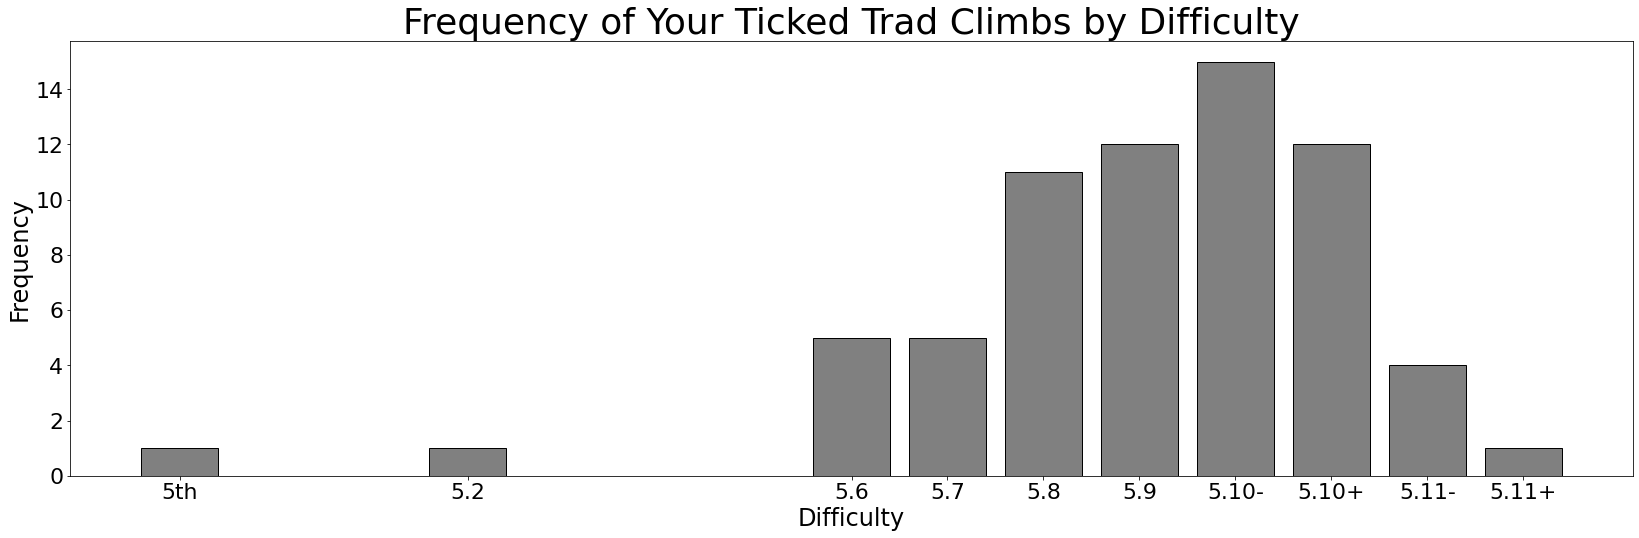

In [305]:
fig, ax = plt.subplots(figsize=(28,8))
climb_buckets = [x["DifficultyBucket"] for x in climbs]
bucket_names = [x["BucketName"] for x in climbs]
climb_freqs = [x["freq"] for x in climbs]

ax.bar(climb_buckets, climb_freqs, color="grey", edgecolor="black");
ax.set_xticks(climb_buckets[::1])
ax.set_xticklabels(bucket_names[::1], fontsize=22);

# ax.set_yticklabels(sorted(climb_freqs), fontsize=22)

ax.set_xlabel("Difficulty", fontsize=24)
ax.set_ylabel("Frequency", fontsize=24)

ax.set_title("Frequency of Your Ticked Trad Climbs by Difficulty", fontsize=36)

plt.savefig("./img/frequency_of_climbs.png")

In [255]:
query = """
select  date_format(to_date(trim(TickDate), 'MMM d, yyyy'), 'EEEE') as weekday,
        dayofweek(to_date(trim(TickDate), 'MMM d, yyyy')) as weekday_int,
        count(*) as tick_count
        --s.TickDate
    from stats s
    inner join routes r
        on r.RouteId = s.RouteId
    where TickDate is not null
      -- and date_format(to_date(trim(TickDate), 'MMM d, yyyy'), 'e') is null
       --and r.Name = 'The Nose'
    group by 1, 2
    order by 2
"""

results = spark.sql(query)
nose_weekdays = results.collect()

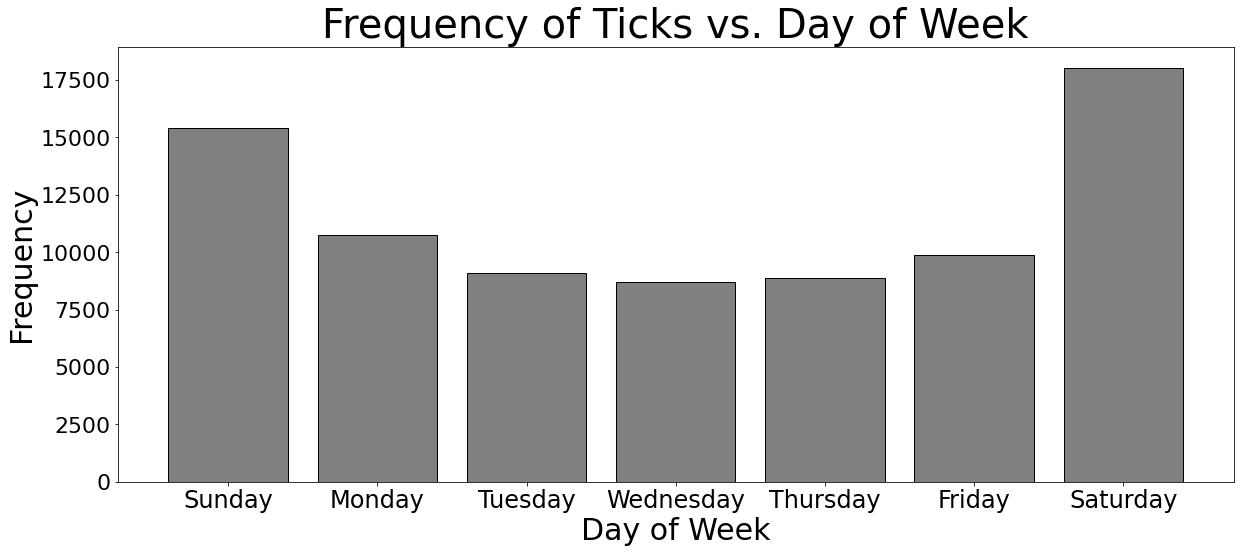

In [256]:
fig, ax = plt.subplots(figsize=(20, 8))

weekdays = [x["weekday_int"] for x in nose_weekdays]
day_labels = [x["weekday"] for x in nose_weekdays]
tick_counts = [x["tick_count"] for x in nose_weekdays]

ax.bar(weekdays, tick_counts, color="grey", edgecolor="black")

ax.set_xticks(weekdays)
ax.set_xticklabels(day_labels, fontsize=24)

ax.set_xlabel("Day of Week", fontsize=30)
ax.set_ylabel("Frequency", fontsize=30)

ax.set_title("Frequency of Ticks vs. Day of Week", fontsize=40)

plt.savefig("./img/nose_ticks_day_of_week.png")

In [252]:
query = """
select *
    from stats
    where TickDate like '%no%'
        --or TickDate is null
"""

results = spark.sql(query)
results.show(100, False)

+------------+-------+--------+--------+---+------+--------+
|ParentAreaId|RouteId|TickDate|TickInfo|URL|UserId|UserName|
+------------+-------+--------+--------+---+------+--------+
+------------+-------+--------+--------+---+------+--------+



In [306]:
query = """
select  r.Name,
        d.BucketName as Difficulty,
        s.TickDate,
        s.TickInfo
    from routes r
    inner join difficultyRef d
        on d.DifficultyRating = r.Difficulty
    inner join stats s
        on s.RouteId = r.RouteId
    where d.RatingSystem = 'YDS'
        and lower(r.Type) like '%trad%'
        --and lower(r.Type) like '%sport%'
        --and lower(s.TickInfo) like '%lead / flash%'
        and s.UserName like '%Christoph von Ruexleben%'
        and d.BucketName = '5.2'
    order by d.DifficultyBucket
"""

results = spark.sql(query)
results.show(10, False) # results.show(200, False)
# climbs

+----------+----------+------------+--------------------------------------------------------------+
|Name      |Difficulty|TickDate    |TickInfo                                                      |
+----------+----------+------------+--------------------------------------------------------------+
|Scaramouch|5.2       |Dec 31, 2019|Lead / Onsight. Easy. With Jenn, Evan, Sabrina, Marta and Adam|
+----------+----------+------------+--------------------------------------------------------------+

